In [1]:
import pandas as pd
import numpy as np

import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def clean_str(text):
    stripped = re.sub('[^0-9,^a-zA-Z, ^А-Я,а-я,Ә,І,Ң,Ғ,Ү,Ұ,Қ,Ө,Һ,ә,і,ə,ң,ғ,ү,ұ,қ,ө,һ]', ' ', str(text).replace('-', ' '))
    stripped = re.sub('_', '', stripped)
    stripped = re.sub('\s+', ' ', stripped)
    return stripped.replace(',','')
    

def cleaning_data(code_data):
    question = code_data.question.tolist()
    answer = code_data.answer.tolist()
    sentences = []
    for line in range(len(question)):
        sentences.append([str(clean_str(question[line])).lower(), 
                          str(clean_str(answer[line])).lower()])
    return pd.DataFrame(sentences, columns = ['question', 'answer'])

In [4]:
df = pd.read_csv('dataset/tarih.csv')
df = cleaning_data(df)
df

,question,answer
0,а байтұрсынұлының 1909 жылы қамалғанға дейінгі...,қарқаралыда оқытушы
1,а байтұрсынов пен м сералин өзі жазбаларында қ...,қостанай
2,а байтұрсыновтың 1911 жылы орынборда жарық көр...,маса
3,а байтұрсыновтың орынборда жарық көрген жинағы,маса
4,а байтұрсыновтың өлеңдер жинағы,маса
...,...,...
15135,xx қозғалыс кезінде және жазалау нәтижесінде қ...,жарты миллион
15136,xx съезден кейін ақталған қайраткер,н нұрмақов
15137,xx съезден кейін ақталған қайраткер,с асфендияров
15138,xxi ғасырдың басында республикадағы мектептер...,8 мыңнан астам


In [5]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['answer'])
df

,question,answer,label
0,а байтұрсынұлының 1909 жылы қамалғанға дейінгі...,қарқаралыда оқытушы,10413
1,а байтұрсынов пен м сералин өзі жазбаларында қ...,қостанай,10526
2,а байтұрсыновтың 1911 жылы орынборда жарық көр...,маса,935
3,а байтұрсыновтың орынборда жарық көрген жинағы,маса,935
4,а байтұрсыновтың өлеңдер жинағы,маса,935
...,...,...,...
15135,xx қозғалыс кезінде және жазалау нәтижесінде қ...,жарты миллион,6551
15136,xx съезден кейін ақталған қайраткер,н нұрмақов,7744
15137,xx съезден кейін ақталған қайраткер,с асфендияров,1103
15138,xxi ғасырдың басында республикадағы мектептер...,8 мыңнан астам,445


In [6]:
df['label'].max()

11154

In [33]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#!wget --no-check-certificate \https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \-O /tmp/bbc-text.csv

In [58]:
vocab_size = 10000
embedding_dim = 16
max_length = 250
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = 0.8

In [77]:
df['label'] = df['label'].astype(str)

In [78]:
sentences = df.question.tolist()
labels = df.label.tolist()

In [79]:
train_size = int(training_portion * len(labels))
train_sentences = sentences[:train_size]
train_labels = labels[:train_size]
validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]
print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

12112
12112
12112
3028
3028


In [80]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding = padding_type, maxlen=max_length)

In [81]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [93]:
model = tf.keras.Sequential([
 tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
 tf.keras.layers.GlobalAveragePooling1D(),
 tf.keras.layers.Dense(24, activation='relu'),
 tf.keras.layers.Dense(11156, activation='linear')
])

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 250, 16)           160000    
_________________________________________________________________
global_average_pooling1d_7 ( (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 24)                408       
_________________________________________________________________
dense_15 (Dense)             (None, 11156)             278900    
Total params: 439,308
Trainable params: 439,308
Non-trainable params: 0
_________________________________________________________________


In [94]:
validation_padded

array([[ 495, 4304,   13, ...,    0,    0,    0],
       [ 495, 4304,   13, ...,    0,    0,    0],
       [2668, 2010,   80, ...,    0,    0,    0],
       ...,
       [1784,    1,   45, ...,    0,    0,    0],
       [   1,  625,  745, ...,    0,    0,    0],
       [   1, 3158,    1, ...,    0,    0,    0]])

In [95]:
validation_label_seq

array([[ 1282],
       [ 9403],
       [ 9404],
       ...,
       [ 1875],
       [11154],
       [11155]])

In [96]:
num_epochs = 20
history = model.fit(train_padded, training_label_seq, epochs = num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/20
379/379 - 2s - loss: 22799042.0000 - accuracy: 8.2563e-05 - val_loss: 60612572.0000 - val_accuracy: 0.0000e+00
Epoch 2/20
379/379 - 2s - loss: 20217112.0000 - accuracy: 8.2563e-05 - val_loss: 52225952.0000 - val_accuracy: 0.0000e+00
Epoch 3/20
379/379 - 2s - loss: 14234663.0000 - accuracy: 8.2563e-05 - val_loss: 39068336.0000 - val_accuracy: 0.0000e+00
Epoch 4/20
379/379 - 2s - loss: 9818874.0000 - accuracy: 8.2563e-05 - val_loss: 30846456.0000 - val_accuracy: 0.0000e+00
Epoch 5/20
379/379 - 2s - loss: 8850404.0000 - accuracy: 8.2563e-05 - val_loss: 28647132.0000 - val_accuracy: 0.0000e+00
Epoch 6/20
379/379 - 2s - loss: 8793908.0000 - accuracy: 8.2563e-05 - val_loss: 28346688.0000 - val_accuracy: 0.0000e+00
Epoch 7/20
379/379 - 2s - loss: 8788723.0000 - accuracy: 8.2563e-05 - val_loss: 28302586.0000 - val_accuracy: 0.0000e+00
Epoch 8/20
379/379 - 2s - loss: 8783048.0000 - accuracy: 8.2563e-05 - val_loss: 28609032.0000 - val_accuracy: 0.0000e+00
Epoch 9/20
379/379 - 2s - los

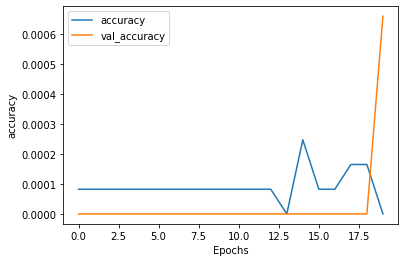

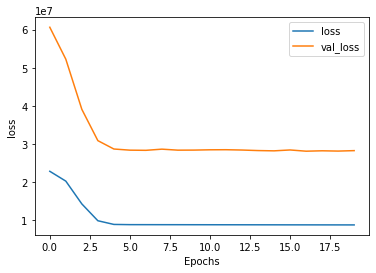

In [97]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")